# Conditional Restricted Boltzmann Machines in Theano

### CRBM training and testing algorithms

@author Graham Taylor

### Main Reference
* Source (Theano): https://gist.github.com/gwtaylor/2505670
* Source (Matlab): http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/code.html
* Reference: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/gwtaylor_nips.pdf

### Mocap data
* Original file: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/motion.mat
* Data originally from Eugene Hsu, MIT. http://people.csail.mit.edu/ehsu/work/sig05stf/

In [1]:
import numpy
import numpy as np
from numpy import arange

import math

import scipy.io
import matplotlib.pyplot as plt
import time

import theano
import theano.tensor as T

from theano.tensor.shared_randomstreams import RandomStreams

### Load Data

In [2]:
def preprocess_data(Motion):

    n_seq = Motion.shape[1]

    # assume data is MIT format for now
    indx = np.r_[
        arange(0,6),arange(6,9),13,arange(18,21),25,arange(30,33),37,arange(42,45),49,arange(54,57),arange(60,63),
        arange(66,69),arange(72,75),arange(78,81),arange(84,87),arange(90,93),arange(96,99),arange(102,105)]

    row1 = Motion[0,0][0]

    offsets =   np.r_[
        row1[None,9:12],row1[None,15:18],row1[None,21:24],row1[None,27:30],row1[None,33:36],row1[None,39:42],
        row1[None,45:48],row1[None,51:54],row1[None,57:60],row1[None,63:66],row1[None,69:72],row1[None,75:78],
        row1[None,81:84],row1[None,87:90],row1[None,93:96],row1[None,99:102],row1[None,105:108]]

    # collapse sequences
    batchdata = np.concatenate([m[:, indx] for m in Motion.flat], axis=0)

    data_mean = batchdata.mean(axis=0)
    data_std = batchdata.std(axis=0)

    batchdata = (batchdata - data_mean) / data_std

    # get sequence lengths
    seqlen = [s.shape[0] for s in Motion.flat]

    return batchdata, seqlen, data_mean, data_std

def load_data(filename):

    # load data post preprocess1
    mat_dict = scipy.io.loadmat(filename)
    Motion = mat_dict['Motion']

    batchdata, seqlen, data_mean, data_std = preprocess_data(Motion)

    # put data into shared memory
    shared_x = theano.shared(np.asarray(batchdata, dtype=theano.config.floatX))

    return shared_x, seqlen, data_mean, data_std

### CRBM Object

In [3]:
class CRBM(object):
    """Conditional Restricted Boltzmann Machine (CRBM)  """
    def __init__(self, input=None, input_history=None, n_visible=49,
        n_hidden=500, delay=6, A=None, B=None, W=None, hbias=None,
        vbias=None, numpy_rng=None,theano_rng=None):
        """
        CRBM constructor. Defines the parameters of the model along with
        basic operations for inferring hidden from visible (and vice-versa),
        as well as for performing CD updates.
        :param input: None for standalone RBMs or symbolic variable if RBM is
        part of a larger graph.
        :param n_visible: number of visible units
        :param n_hidden: number of hidden units
        :param A: None for standalone CRBMs or symbolic variable pointing to a
        shared weight matrix in case CRBM is part of a CDBN network; in a CDBN,
        the weights are shared between CRBMs and layers of a MLP
        :param B: None for standalone CRBMs or symbolic variable pointing to a
        shared weight matrix in case CRBM is part of a CDBN network; in a CDBN,
        the weights are shared between CRBMs and layers of a MLP
        :param W: None for standalone CRBMs or symbolic variable pointing to a
        shared weight matrix in case CRBM is part of a CDBN network; in a CDBN,
        the weights are shared between CRBMs and layers of a MLP
        :param hbias: None for standalone CRBMs or symbolic variable pointing
        to a shared hidden units bias vector in case CRBM is part of a
        different network
        :param vbias: None for standalone RBMs or a symbolic variable
        pointing to a shared visible units bias
        """

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.delay = delay

        if numpy_rng is None:
            # create a number generator
            numpy_rng = numpy.random.RandomState(1234)

        if theano_rng is None:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        if W is None:
            # the output of uniform if converted using asarray to dtype
            # theano.config.floatX so that the code is runable on GPU
            initial_W = np.asarray(0.01 * numpy_rng.randn(n_visible,n_hidden),dtype=theano.config.floatX)
            # theano shared variables for weights and biases
            W = theano.shared(value=initial_W, name='W')

        if A is None:
            initial_A = np.asarray(0.01 * numpy_rng.randn(n_visible * delay,n_visible),dtype=theano.config.floatX)
            # theano shared variables for weights and biases
            A = theano.shared(value=initial_A, name='A')

        if B is None:
            initial_B = np.asarray(0.01 * numpy_rng.randn(n_visible * delay, n_hidden), dtype=theano.config.floatX)
            # theano shared variables for weights and biases
            B = theano.shared(value=initial_B, name='B')

        if hbias is None:
            # create shared variable for hidden units bias
            hbias = theano.shared(value=numpy.zeros(n_hidden,
                    dtype=theano.config.floatX), name='hbias')

        if vbias is None:
            # create shared variable for visible units bias
            vbias = theano.shared(value=numpy.zeros(n_visible,
                    dtype=theano.config.floatX), name='vbias')

        # initialize input layer for standalone CRBM or layer0 of CDBN
        self.input = input
        if not input:
            self.input = T.matrix('input')

        self.input_history = input_history
        if not input_history:
            self.input_history = T.matrix('input_history')

        self.W = W
        self.A = A
        self.B = B
        self.hbias = hbias
        self.vbias = vbias
        self.theano_rng = theano_rng
        # **** WARNING: It is not a good idea to put things in this list
        # other than shared variables created in this function.
        self.params = [self.W, self.A, self.B, self.hbias, self.vbias]

    def free_energy(self, v_sample, v_history):
        ''' Function to compute the free energy of a sample conditional
        on the history '''
        wx_b = T.dot(v_sample, self.W) + T.dot(v_history, self.B) + self.hbias
        ax_b = T.dot(v_history, self.A) + self.vbias
        visible_term = T.sum(0.5 * T.sqr(v_sample - ax_b), axis=1)
        hidden_term = T.sum(T.log(1 + T.exp(wx_b)), axis=1)

        return visible_term - hidden_term

    def propup(self, vis, v_history):
        ''' This function propagates the visible units activation upwards to
        the hidden units
        Note that we return also the pre-sigmoid activation of the layer. As
        it will turn out later, due to how Theano deals with optimizations,
        this symbolic variable will be needed to write down a more
        stable computational graph (see details in the reconstruction cost
        function)
        '''
        pre_sigmoid_activation = T.dot(vis, self.W) + \
                         T.dot(v_history, self.B) + self.hbias
        return [pre_sigmoid_activation, T.nnet.sigmoid(pre_sigmoid_activation)]

    def sample_h_given_v(self, v0_sample, v_history):
        ''' This function infers state of hidden units given visible units '''
        # compute the activation of the hidden units given a sample of the
        # visibles
        #pre_sigmoid_h1, h1_mean = self.propup(v0_sample)
        pre_sigmoid_h1, h1_mean = self.propup(v0_sample, v_history)
        # get a sample of the hiddens given their activation
        # Note that theano_rng.binomial returns a symbolic sample of dtype
        # int64 by default. If we want to keep our computations in floatX
        # for the GPU we need to specify to return the dtype floatX
        h1_sample = self.theano_rng.binomial(size=h1_mean.shape, n=1,
                                     p=h1_mean,
                                     dtype=theano.config.floatX)
        return [pre_sigmoid_h1, h1_mean, h1_sample]

    def propdown(self, hid, v_history):
        '''This function propagates the hidden units activation downwards to
        the visible units
        Note that we return also the pre_sigmoid_activation of the layer. As
        it will turn out later, due to how Theano deals with optimizations,
        this symbolic variable will be needed to write down a more
        stable computational graph (see details in the reconstruction cost
        function)
        '''
        mean_activation = T.dot(hid, self.W.T) + T.dot(v_history, self.A) + \
                  self.vbias
        return mean_activation

    def sample_v_given_h(self, h0_sample, v_history):
        ''' This function infers state of visible units given hidden units '''
        # compute the activation of the visible given the hidden sample
        #pre_sigmoid_v1, v1_mean = self.propdown(h0_sample)
        v1_mean = self.propdown(h0_sample, v_history)
        # get a sample of the visible given their activation
        # Note that theano_rng.binomial returns a symbolic sample of dtype
        # int64 by default. If we want to keep our computations in floatX
        # for the GPU we need to specify to return the dtype floatX
        #v1_sample = self.theano_rng.binomial(size=v1_mean.shape,
        #                                     n=1, p=v1_mean,
        #        dtype = theano.config.floatX)
        v1_sample = v1_mean  # mean-field
        return [v1_mean, v1_sample]

    def gibbs_hvh(self, h0_sample, v_history):
        ''' This function implements one step of Gibbs sampling,
            starting from the hidden state'''
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample, v_history)
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v1_sample,
                                                           v_history)

        return [v1_mean, v1_sample, pre_sigmoid_h1, h1_mean, h1_sample]

    def gibbs_vhv(self, v0_sample, v_history):
        ''' This function implements one step of Gibbs sampling,
            starting from the visible state'''
        #pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v0_sample)
        #pre_sigmoid_v1, v1_mean, v1_sample = self.sample_v_given_h(h1_sample)
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v0_sample,
                                                           v_history)
        v1_mean, v1_sample = self.sample_v_given_h(h1_sample, v_history)

        return [pre_sigmoid_h1, h1_mean, h1_sample, v1_mean, v1_sample]

    def get_cost_updates(self, lr=0.1, k=1):
        """
        This functions implements one step of CD-k
        :param lr: learning rate used to train the RBM
        :param persistent: None for CD
        :param k: number of Gibbs steps to do in CD-k
        Returns a proxy for the cost and the updates dictionary. The
        dictionary contains the update rules for weights and biases but
        also an update of the shared variable used to store the persistent
        chain, if one is used.
        """

        # compute positive phase
        pre_sigmoid_ph, ph_mean, ph_sample = \
                self.sample_h_given_v(self.input, self.input_history)

        # for CD, we use the newly generate hidden sample
        chain_start = ph_sample

        # perform actual negative phase
        # in order to implement CD-k we need to scan over the
        # function that implements one gibbs step k times.
        # Read Theano tutorial on scan for more information :
        # http://deeplearning.net/software/theano/library/scan.html
        # the scan will return the entire Gibbs chain
        # updates dictionary is important because it contains the updates
        # for the random number generator
        [nv_means, nv_samples, pre_sigmoid_nhs, nh_means,
         nh_samples], updates = theano.scan(self.gibbs_hvh,
                # the None are place holders, saying that
                # chain_start is the initial state corresponding to the
                # 5th output
                outputs_info=[None, None, None, None, chain_start],
                non_sequences=self.input_history,
                n_steps=k)

        # determine gradients on CRBM parameters
        # not that we only need the sample at the end of the chain
        chain_end = nv_samples[-1]

        cost = T.mean(self.free_energy(self.input, self.input_history)) - \
               T.mean(self.free_energy(chain_end, self.input_history))

        # We must not compute the gradient through the gibbs sampling
        gparams = T.grad(cost, self.params, consider_constant=[chain_end])

        # constructs the update dictionary
        for gparam, param in zip(gparams, self.params):
            # make sure that the learning rate is of the right dtype
            if param == self.A:
                # slow down autoregressive updates
                updates[param] = param - gparam * 0.01 * \
                     T.cast(lr, dtype=theano.config.floatX)
            else:
                updates[param] = param - gparam * \
                     T.cast(lr, dtype=theano.config.floatX)

        # reconstruction error is a better proxy for CD
        monitoring_cost = self.get_reconstruction_cost(updates, nv_means[-1])

        return monitoring_cost, updates

    def get_reconstruction_cost(self, updates, pre_sigmoid_nv):
        """Approximation to the reconstruction error
        """
        # sum over dimensions, mean over cases
        recon = T.mean(T.sum(T.sqr(self.input - pre_sigmoid_nv), axis=1))

        return recon

    def generate(self, orig_data, orig_history, n_samples, n_gibbs=30):
        """ Given initialization(s) of visibles and matching history, generate
        n_samples in future.
        orig_data : n_seq by n_visibles array
            initialization for first frame
        orig_history : n_seq by delay * n_visibles array
            delay-step history
        n_samples : int
            number of samples to generate forward
        n_gibbs : int
            number of alternating Gibbs steps per iteration"""
        n_seq = orig_data.shape[0]
        persistent_vis_chain = theano.shared(orig_data)
        persistent_history = theano.shared(orig_history)

        #persistent_history = T.matrix('persistent_history')

        [presig_hids, hid_mfs, hid_samples, vis_mfs, vis_samples], updates =  \
                    theano.scan(crbm.gibbs_vhv,
                            outputs_info=[None, None, None, None,
                                            persistent_vis_chain],
                            non_sequences=persistent_history,
                            n_steps=n_gibbs)

        # add to updates the shared variable that takes care of our persistent
        # chain
        # initialize next visible with current visible
        # shift the history one step forward
        updates.update({persistent_vis_chain: vis_samples[-1],
                 persistent_history: T.concatenate(
                     (vis_samples[-1],
                         persistent_history[:, :(self.delay - 1) * \
                                            self.n_visible],
                      ), axis=1)})
        # construct the function that implements our persistent chain.
        # we generate the "mean field" activations for plotting and the actual
        # samples for reinitializing the state of our persistent chain
        sample_fn = theano.function([], [vis_mfs[-1], vis_samples[-1]],
                    updates=updates,
                    name='sample_fn')

        #vis_mf, vis_sample = sample_fn()
        #print orig_data[:,1:5]
        #print vis_mf[:,1:5]
        generated_series = np.empty((n_seq, n_samples, self.n_visible))
        for t in xrange(n_samples):
            if t % 10 == 0:
                print ("Generating frame %d to %d" % (t, min(t+9, n_samples)))
            vis_mf, vis_sample = sample_fn()
            generated_series[:, t, :] = vis_mf
        return generated_series

### Train the CRBM function

In [4]:
def train_crbm(learning_rate=1e-3, training_epochs=300,
             dataset='motion.mat', batch_size=100,
             n_hidden=100, delay=6):
    """
    Demonstrate how to train a CRBM.
    This is demonstrated on mocap data.
    :param learning_rate: learning rate used for training the CRBM
    :param training_epochs: number of epochs used for training
    :param dataset: path the the dataset (matlab format)
    :param batch_size: size of a batch used to train the RBM
    """

    rng = numpy.random.RandomState(123)
    theano_rng = RandomStreams(rng.randint(2 ** 30))

    # batchdata is returned as theano shared variable floatX
    batchdata, seqlen, data_mean, data_std = load_data(dataset)

    # compute number of minibatches for training, validation and testing
    n_train_batches = batchdata.get_value(borrow=True).shape[0] / batch_size
    n_dim = batchdata.get_value(borrow=True).shape[1]

    # valid starting indices
    batchdataindex = []
    last = 0
    for s in seqlen:
        batchdataindex += range(last + delay, last + s)
        last += s

    permindex = np.array(batchdataindex)
    rng.shuffle(permindex)

    # allocate symbolic variables for the data
    index = T.lvector()    # index to a [mini]batch
    index_hist = T.lvector()  # index to history
    x = T.matrix('x')  # the data
    x_history = T.matrix('x_history')

    #theano.config.compute_test_value='warn'
    #x.tag.test_value = np.random.randn(batch_size, n_dim)
    #x_history.tag.test_value = np.random.randn(batch_size, n_dim*delay)

    # initialize storage for the persistent chain
    # (state = hidden layer of chain)

    # construct the CRBM class
    crbm = CRBM(input=x, input_history=x_history, n_visible=n_dim, \
                n_hidden=n_hidden, delay=delay, numpy_rng=rng,
                theano_rng=theano_rng)

    # get the cost and the gradient corresponding to one step of CD-15
    cost, updates = crbm.get_cost_updates(lr=learning_rate, k=1)

    #################################
    #     Training the CRBM         #
    #################################

    # the purpose of train_crbm is solely to update the CRBM parameters
    train_crbm = theano.function(
                                inputs=[index, index_hist], 
                                outputs = [cost],
           updates=updates,
           givens={x: batchdata[index], \
                      x_history: batchdata[index_hist].reshape((
                       batch_size, delay * n_dim))},
           name='train_crbm')

    plotting_time = 0.
    start_time = time.clock()

    # go through training epochs
    for epoch in xrange(training_epochs):

        # go through the training set
        mean_cost = []
        for batch_index in xrange(n_train_batches):

            # indexing is slightly complicated
            # build a linear index to the starting frames for this batch
            # (i.e. time t) gives a batch_size length array for data
            data_idx = permindex[batch_index * batch_size:(batch_index + 1) \
                                 * batch_size]

            # now build a linear index to the frames at each delay tap
            # (i.e. time t-1 to t-delay)
            # gives a batch_size x delay array of indices for history
            hist_idx = np.array([data_idx - n for n in xrange(1, delay + 1)]).T

            this_cost = train_crbm(data_idx, hist_idx.ravel())

            #print batch_index, this_cost
            mean_cost += [this_cost]

        if epoch % 10 == 0:
            print ('Training epoch %d, cost is ' % epoch, numpy.mean(mean_cost))

    end_time = time.clock()

    pretraining_time = (end_time - start_time)

    print ('Training took %f minutes' % (pretraining_time / 60.))

    return crbm, batchdata

### Main Program Entry Point

In [49]:
crbm, batchdata = train_crbm(dataset='./datasets/motion.mat')

('Training epoch 0, cost is ', 50.016278992397936)
('Training epoch 10, cost is ', 35.404225027223958)
('Training epoch 20, cost is ', 30.265989162335035)
('Training epoch 30, cost is ', 27.00175395752856)
('Training epoch 40, cost is ', 24.765969952131655)
('Training epoch 50, cost is ', 22.953236295284274)
('Training epoch 60, cost is ', 21.437960758918248)
('Training epoch 70, cost is ', 20.333441114663852)
('Training epoch 80, cost is ', 19.422713901159831)
('Training epoch 90, cost is ', 18.580761661851756)
('Training epoch 100, cost is ', 17.921438598012021)
('Training epoch 110, cost is ', 17.366657463120177)
('Training epoch 120, cost is ', 16.939138842704178)
('Training epoch 130, cost is ', 16.530969294317508)
('Training epoch 140, cost is ', 16.076173523221268)
('Training epoch 150, cost is ', 15.796054217641917)
('Training epoch 160, cost is ', 15.52236039595827)
('Training epoch 170, cost is ', 15.271607275761321)
('Training epoch 180, cost is ', 15.059949882468716)
('Trai

Generate some sequences (in parallel) from CRBM

* Using training data as initialization
* pick some starting points for each sequence

In [50]:
data_idx = np.array([100, 200, 400, 600])
orig_data = numpy.asarray(batchdata.get_value(borrow=True)[data_idx], dtype=theano.config.floatX)

hist_idx = np.array([data_idx - n for n in range(1, crbm.delay + 1)]).T
hist_idx = hist_idx.ravel()

orig_history = numpy.asarray(
    batchdata.get_value(borrow=True)[hist_idx].reshape(
    (len(data_idx), crbm.delay * crbm.n_visible)),
    dtype=theano.config.floatX)

In [56]:
generated_series_tmp = crbm.generate(orig_data, orig_history, n_samples=100, n_gibbs=30)

# append initialization
generated_series = np.concatenate((orig_history.reshape(len(data_idx), crbm.delay, crbm.n_visible )[:, ::-1, :],
                                   generated_series_tmp), axis=1)

/home/berral/.local/lib/python2.7/site-packages/ipykernel/__main__.py:269: UserWarning: Updating an `OrderedUpdates` with a non-ordered dictionary with 2+ elements could make your code non-deterministic


Generating frame 0 to 9
Generating frame 10 to 19
Generating frame 20 to 29
Generating frame 30 to 39
Generating frame 40 to 49
Generating frame 50 to 59
Generating frame 60 to 69
Generating frame 70 to 79
Generating frame 80 to 89
Generating frame 90 to 99


In [57]:
bd = batchdata.get_value(borrow=True)

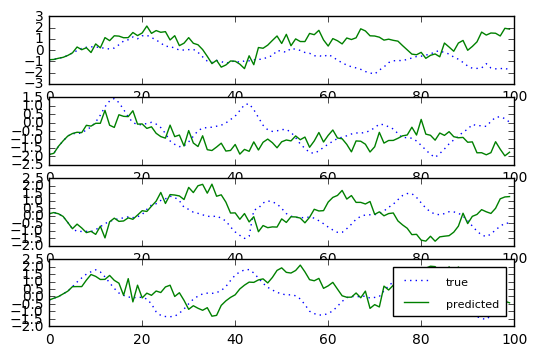

In [80]:
# plot first dimension of each sequence
for i in xrange(len(generated_series)):
    # original
    start = data_idx[i]
    
    plt.subplot(len(generated_series), 1, i + 1)
    plt.plot(bd[start - crbm.delay:start + 100 - crbm.delay, 1], label='true', linestyle=':')
    plt.plot(generated_series[i,:100,1], label='predicted', linestyle='-')

leg = plt.legend()
ltext = leg.get_texts()  # all the text.Text instance in the legend
plt.setp(ltext, fontsize=8)
plt.show()